## Model Fitting with Scikit-Learn

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [29]:
from sklearn.linear_model import LinearRegression, Lasso

In [17]:
np.random.seed(3333)
num_samples = 5

true_a = 0.5
true_b = 3.0
true_c = 1.2
X = np.linspace(-10, 10, 100)[:, None]
Y = true_a + true_b*X + true_c*X**2 + 20*np.random.randn(100)[:,None]
index = np.random.choice(range(X.shape[0]), num_samples)
mask = np.isin(range(X.shape[0]), index)
X_sample = X[mask]
Y_sample = Y[mask]
X_test = X[~mask]
Y_test = Y[~mask]

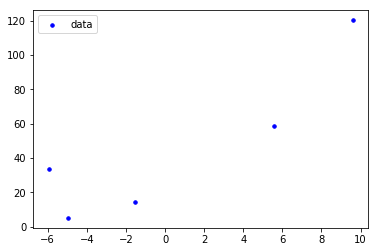

In [30]:
plt.scatter(X_sample, Y_sample, s=12, c='b', label="data")
plt.legend(loc='upper left')
fig = plt.gcf()
fig.savefig("./images/linear_data.png")

## Overfitting

In [2]:
from sklearn.preprocessing import PolynomialFeatures

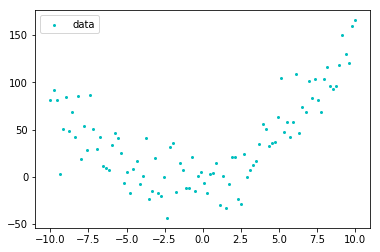

In [25]:
plt.scatter(X, Y, s=4, c='c', label="true data")
plt.legend(loc="upper left")
fig = plt.gcf()
fig.savefig("./images/overfit_all_data.png")

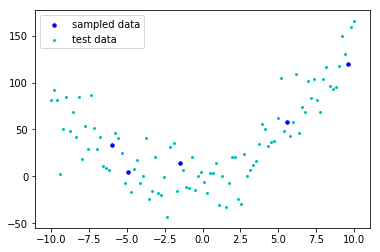

In [24]:
plt.scatter(X_sample, Y_sample, s=12, c='b', label="sampled data")
plt.scatter(X_test, Y_test, s=4, c='c', label="test data")
plt.legend(loc='upper left')
fig = plt.gcf()
fig.savefig("./images/overfit_split_data.png")

In [5]:
X_sample.shape, Y_sample.shape

((5, 1), (5, 1))

In [6]:
def fit_model(X, Y, degree=None):
    if degree:
        poly_feature = PolynomialFeatures(degree=degree, 
                                          include_bias=False)
        X_train = poly_feature.fit_transform(X)
    else:
        X_train = X
    Y_train = Y.copy()
    model = LinearRegression()
    model.fit(X_train, Y_train)
    return model

In [7]:
model_d4 = fit_model(X_sample, Y_sample, num_samples-1)
model_d2 = fit_model(X_sample, Y_sample, 2)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [8]:
model_d4.intercept_, model_d4.coef_

(array([ 34.91293339]),
 array([[ 12.88003561,  -1.06233458,  -0.30357516,   0.03865172]]))

In [10]:
model_d2.intercept_, model_d2.coef_

(array([ 14.2387912]), array([[ 3.27020065,  0.81675069]]))

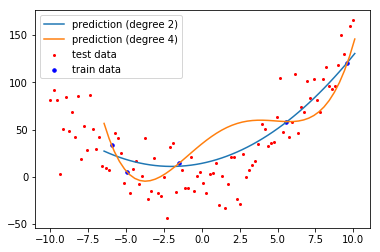

In [9]:
x_ori = np.linspace(X_sample.min()-0.5, X_sample.max()+0.5, 50)
x_d4 = PolynomialFeatures(degree=4, include_bias=False).fit_transform(x_ori[:,None])
y_d4 = model_d4.predict(x_d4)
x_d2 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_ori[:,None])
y_d2 = model_d2.predict(x_d2)
plt.scatter(X_test, Y_test, s=4, c='r', label="test data")
plt.scatter(X_sample, Y_sample, s=12, c='b', label="train data")
plt.plot(x_ori, y_d2.flatten(), label="prediction (degree 2)")
plt.plot(x_ori, y_d4.flatten(), label="prediction (degree 4)")
plt.legend()

## Pipeline

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

In [46]:
print(Pipeline.__doc__)

Pipeline of transforms with a final estimator.

    Sequentially apply a list of transforms and a final estimator.
    Intermediate steps of the pipeline must be 'transforms', that is, they
    must implement fit and transform methods.
    The final estimator only needs to implement fit.
    The transformers in the pipeline can be cached using ``memory`` argument.

    The purpose of the pipeline is to assemble several steps that can be
    cross-validated together while setting different parameters.
    For this, it enables setting parameters of the various steps using their
    names and the parameter name separated by a '__', as in the example below.
    A step's estimator may be replaced entirely by setting the parameter
    with its name to another estimator, or a transformer removed by setting
    to None.

    Read more in the :ref:`User Guide <pipeline>`.

    Parameters
    ----------
    steps : list
        List of (name, transform) tuples (implementing fit/transform) that a

In [56]:
poly_feature_d2 = PolynomialFeatures(degree=2, include_bias=False)
poly_feature_d4 = PolynomialFeatures(degree=4, include_bias=False)
pipe_d2 = Pipeline(steps=[("features_d2", poly_feature_d2), ("model", LinearRegression())])
pipe_d4 = Pipeline(steps=[("features_d4", poly_feature_d4), ("model", LinearRegression())])

In [59]:
pipe_d2.fit(X_sample, Y_sample)

Pipeline(memory=None,
     steps=[('features_d2', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [60]:
pipe_d4.fit(X_sample, Y_sample)

Pipeline(memory=None,
     steps=[('features_d4', PolynomialFeatures(degree=4, include_bias=False, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

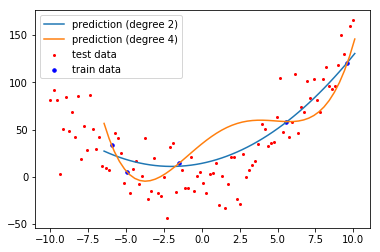

In [98]:
x_ = np.linspace(X_sample.min()-0.5, X_sample.max()+0.5, 50)
y_d2 = pipe_d2.predict(x_.reshape((-1, 1)))
y_d4 = pipe_d4.predict(x_.reshape((-1, 1)))
plt.scatter(X_test, Y_test, s=4, c='r', label="test data")
plt.scatter(X_sample, Y_sample, s=12, c='b', label="train data")
plt.plot(x_, y_d2.flatten(), label="prediction (degree 2)")
plt.plot(x_, y_d4.flatten(), label="prediction (degree 4)")
plt.legend()

## Evaluation

- [scoring](http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)

In [117]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

### In-Sample

In [90]:
err_d2 = mean_squared_error(pipe_d2.predict(X_sample), Y_sample)
err_d4 = mean_squared_error(pipe_d4.predict(X_sample), Y_sample)
print("Is model degree 2 better than model degree 4 (mean square error)? ",
      err_d2 < err_d4 and "Yes" or "No")
print("{:.2f} v.s {:.2f}".format(err_d2, err_d4))

Is model degree 2 better than model degree 4 (mean square error)?  No
54.20 v.s 0.00


In [91]:
r2_d2 = r2_score(pipe_d2.predict(X_sample), Y_sample)
r2_d4 = r2_score(pipe_d4.predict(X_sample), Y_sample)
print("Is model degree 2 better than model degree 4 (R^2)? ",
      r2_d2 >= r2_d4 and "Yes" or "No")
print("{:.2f} v.s {:.2f}".format(r2_d2, r2_d4))

Is model degree 2 better than model degree 4 (R^2)?  No
0.97 v.s 1.00


### Out-Sample

In [92]:
err_d2 = mean_squared_error(pipe_d2.predict(X_test), Y_test)
err_d4 = mean_squared_error(pipe_d4.predict(X_test), Y_test)
print("Is model degree 2 better than model degree 4 (mean square error)? ",
      err_d2 < err_d4 and "Yes" or "No")
print("{:.2f} v.s {:.2f}".format(err_d2, err_d4))

Is model degree 2 better than model degree 4 (mean square error)?  Yes
606.88 v.s 10006.30


In [95]:
r2_d2 = r2_score(pipe_d2.predict(X_test), Y_test)
r2_d4 = r2_score(pipe_d4.predict(X_test), Y_test)
print("Is model degree 2 better than model degree 4 (R^2)? ",
      r2_d2 >= r2_d4 and "Yes" or "No")
print("{:.2f} v.s {:.2f}".format(r2_d2, r2_d4))

Is model degree 2 better than model degree 4 (R^2)?  Yes
0.36 v.s -0.04


## Model Selection with Pipeline

In [102]:
from sklearn.model_selection import GridSearchCV

In [136]:
np.random.seed(3333)
num_samples = 20

index = np.random.choice(range(X.shape[0]), num_samples)
mask = np.isin(range(X.shape[0]), index)
X_sample = X[mask]
Y_sample = Y[mask]
X_test = X[~mask]
Y_test = Y[~mask]

In [142]:
X_sample.shape, Y_sample.shape

((18, 1), (18, 1))

In [173]:
pipe = Pipeline(steps=[("poly_feature", PolynomialFeatures(degree=3, include_bias=False)),
                       ("model", LinearRegression())])

In [181]:
param_grid = dict(poly_feature__degree=[1, 2, 3, 4],
                  model__normalize=[False, True])

In [182]:
searcher = GridSearchCV(pipe, param_grid=param_grid, 
                        scoring=make_scorer(mean_squared_error, 
                                            greater_is_better=False),
                        verbose=True)

In [183]:
searcher.fit(X_sample, Y_sample)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly_feature', PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'poly_feature__degree': [1, 2, 3, 4], 'model__normalize': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=True)

In [184]:
searcher.estimator.fit(X_sample, Y_sample)

Pipeline(memory=None,
     steps=[('poly_feature', PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [185]:
best_model = searcher.best_estimator_

In [186]:
y_ = searcher.estimator.predict(X_test)
Y_ = best_model.predict(X_test)

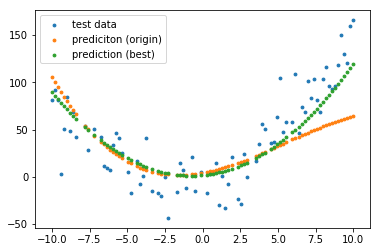

In [187]:
plt.scatter(X_test, Y_test, label="test data", s=8)
plt.scatter(X_test, y_, label="prediciton (origin)", s=8)
plt.scatter(X_test, Y_, label="prediction (best)", s=8)
plt.legend()

## What Else Can I Use in a Pipeline?

In [58]:
print("Is poly_feature a BaseEstimator?", isinstance(poly_feature, BaseEstimator) and "Yes" or "No")
print("Is LinearRegression() a BaseEstimator?", isinstance(pipe_d2.named_steps["model"], BaseEstimator) and "Yes" or "No")
print("Is pipe a BaseEstimator?", isinstance(pipe, BaseEstimator) and "Yes" or "No")
print("Is r2_score a BaseEstimator?", isinstance(r2_score, BaseEstimator) and "Yes" or "No")

Is poly_feature a BaseEstimator? Yes
Is LinearRegression() a BaseEstimator? Yes
Is pipe a BaseEstimator? Yes
Is r2_score a BaseEstimator? No
